# SNF naive analysis on LURIC data set

For this analysis we will use a subset of SNPs ($N=189$) significantly associated with the metabolite data, and 27 different metabolites.

In [1]:
#### LIBRARIES
library(igraph)
library(SNFtool)
library(ggplot2)
library(CiteFuse)
library(RColorBrewer)
source('SpectralClustering.R')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘CiteFuse’


The following object is masked from ‘package:SNFtool’:

    spectralClustering




In [2]:
#### SET PATHS
setwd('../')
mainpath <- getwd()
datapath <- paste0(mainpath, '/Data')

In [3]:
#### LOAD DATA
setwd(datapath)
dat1 <- read.table('LURIC/LURIC_idpat_final_relRem_geno99_mind99_maf05_pruned.raw', header=TRUE) #genotypes
dat2 <- read.table('LURIC/MWAS_27metab2572s.txt', header=TRUE) #Metabolite data

In [4]:
#### SPLIT DATA, RETAIN COMPLETE CASES, AND INTERSECT DATA SETS
#Retain complete snp data
snp  <- dat1[,7:195]
bool <- complete.cases(snp)
snp  <- snp[bool,]
dat1 <- dat1[bool,]

#Intersect
dat <- merge(dat1, dat2, by.x='IID', by.y='idpat')

#Split
snp <- dat[,7:195]
met <- dat[,214:240]
cov <- dat[,c(196:199,201:213)]
pheno <- dat[,200]

# SNF pipeline

In [5]:
#### NORMALIZE METABOLITE DATA
met <- scale(met)

#### CALCULATE DISTANCES
snp_dist <- chiDist2(snp)
met_dist <- dist2(met, met)

#### ESTIMATE SIMILARITY GRAPHS
K     <- 10
alpha <- 0.5
W1 <- affinityMatrix(met_dist, K, alpha)
W2 <- affinityMatrix(snp_dist, K, alpha)

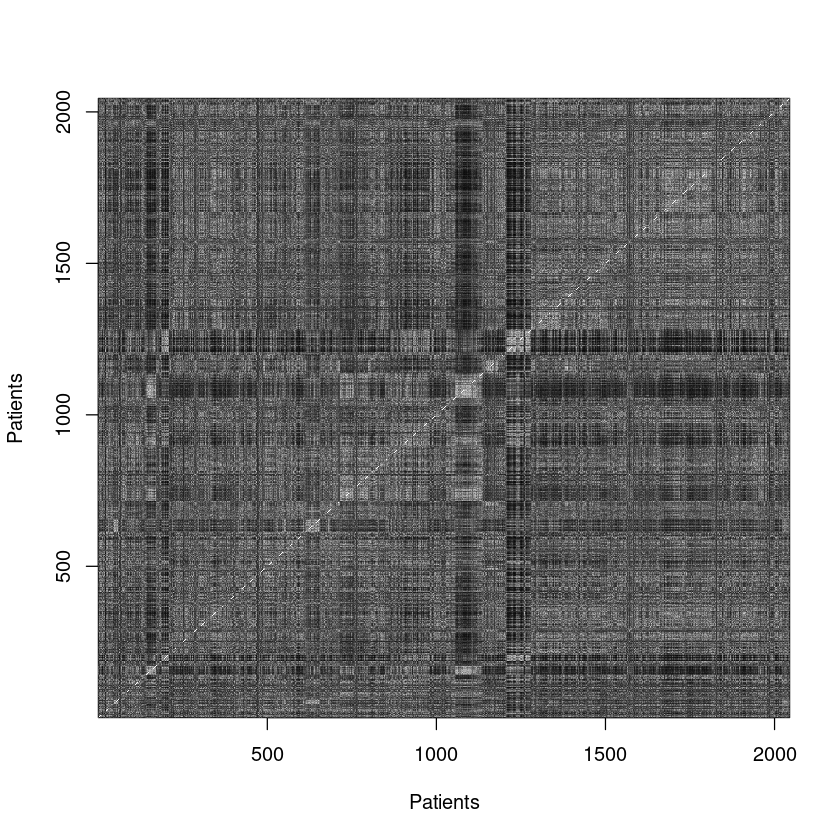

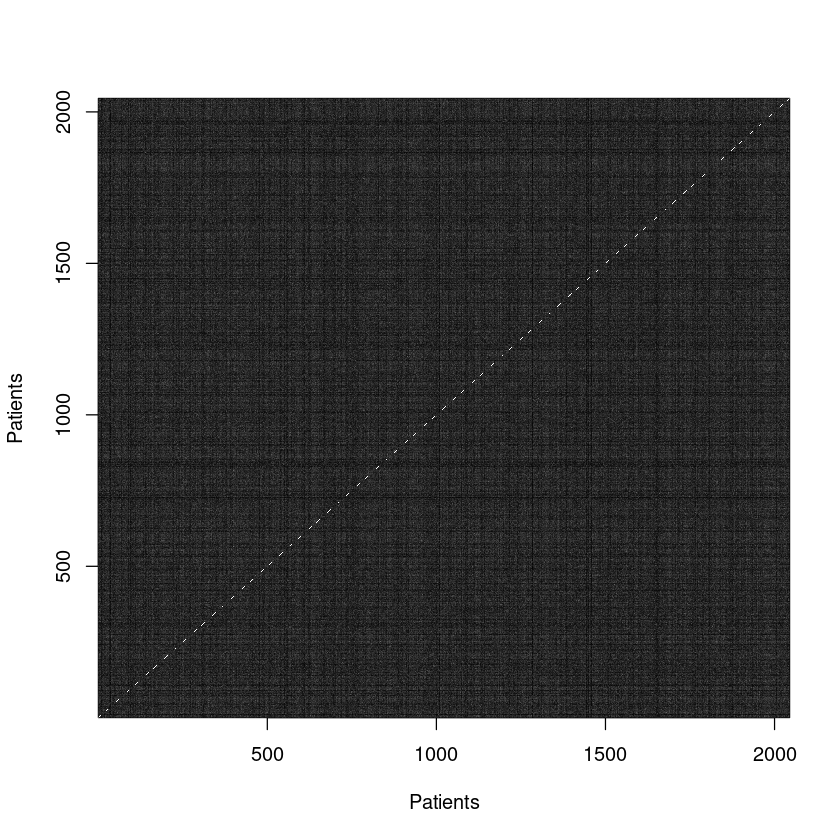

In [6]:
displayClusters(log(W1), as.factor(pheno))
displayClusters(log(W2), as.factor(pheno))

In [7]:
#### RUN SNF
T <- 40
W <- SNF(list(W1,W2), K, T)

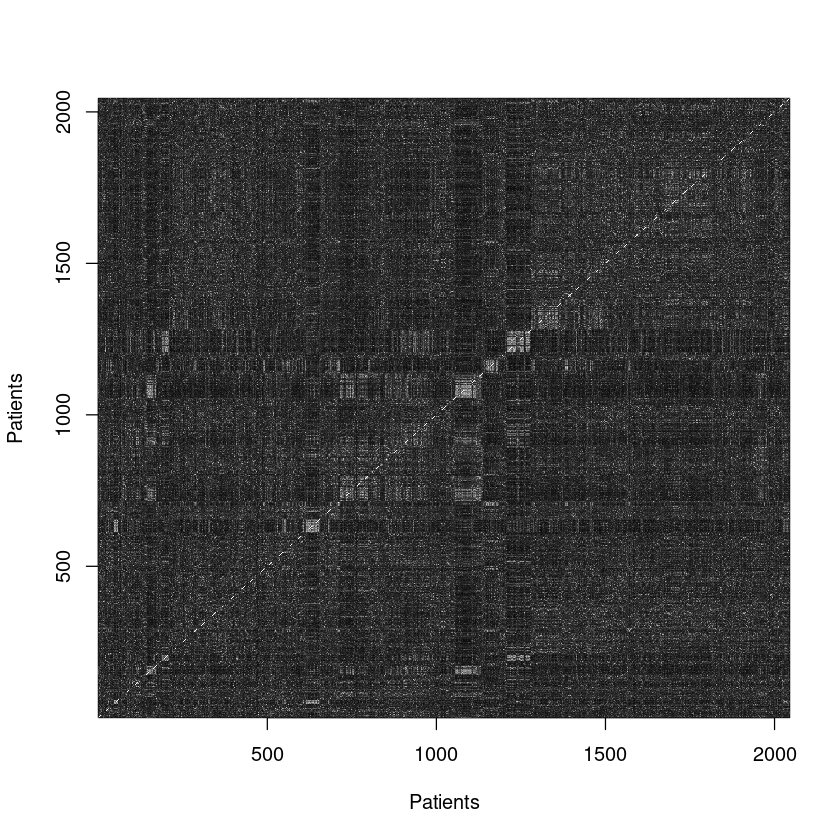

In [8]:
displayClusters(log(W), as.factor(pheno))

# Spectral Clustering

In [9]:
SNF_W_clust <- spectralClust(W, 20)

[1] 2

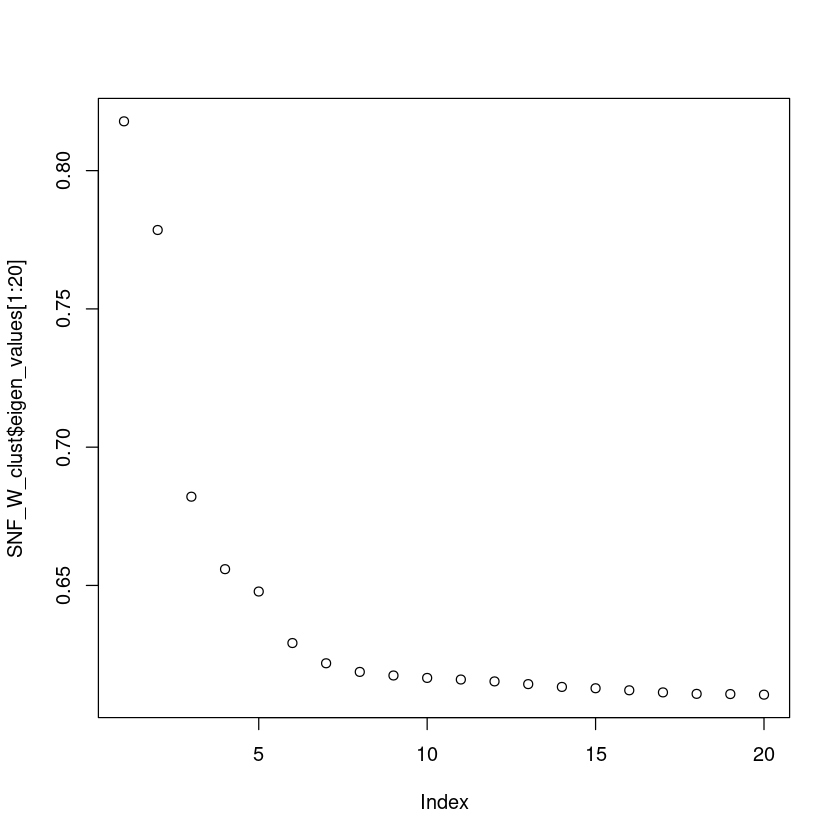

In [10]:
#### HOW MANY CLUSTERS?
plot(SNF_W_clust$eigen_values[1:20])
which.max(abs(diff(SNF_W_clust$eigen_values)))

In [11]:
SNF_W_clust  <- spectralClust(W,  K = 2)
SNF_W1_clust <- spectralClust(W1, K = 2)
SNF_W2_clust <- spectralClust(W2, K = 2)

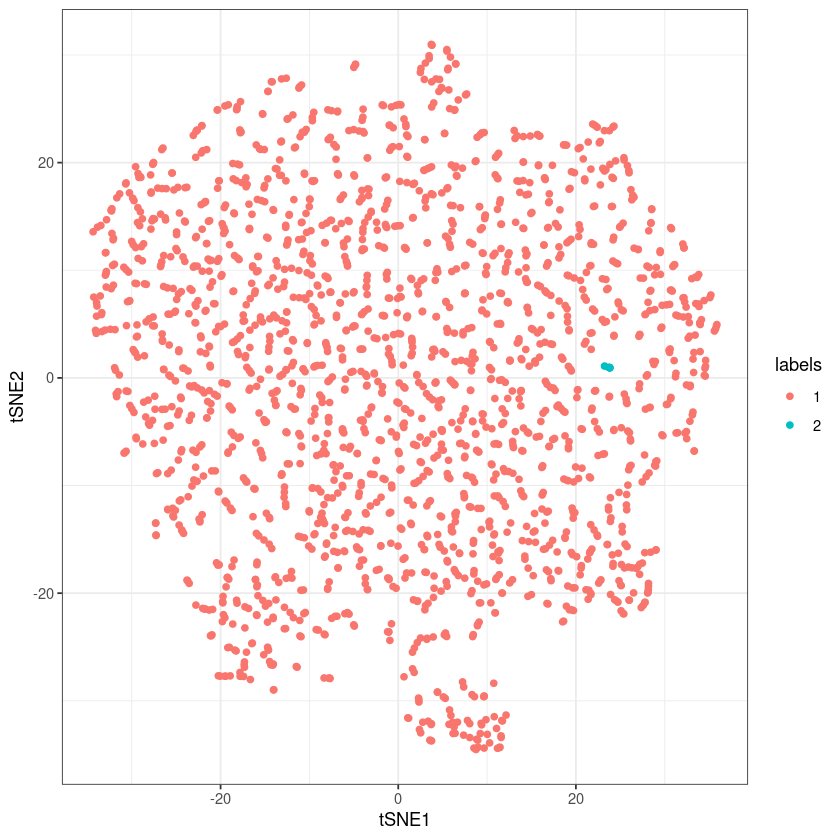

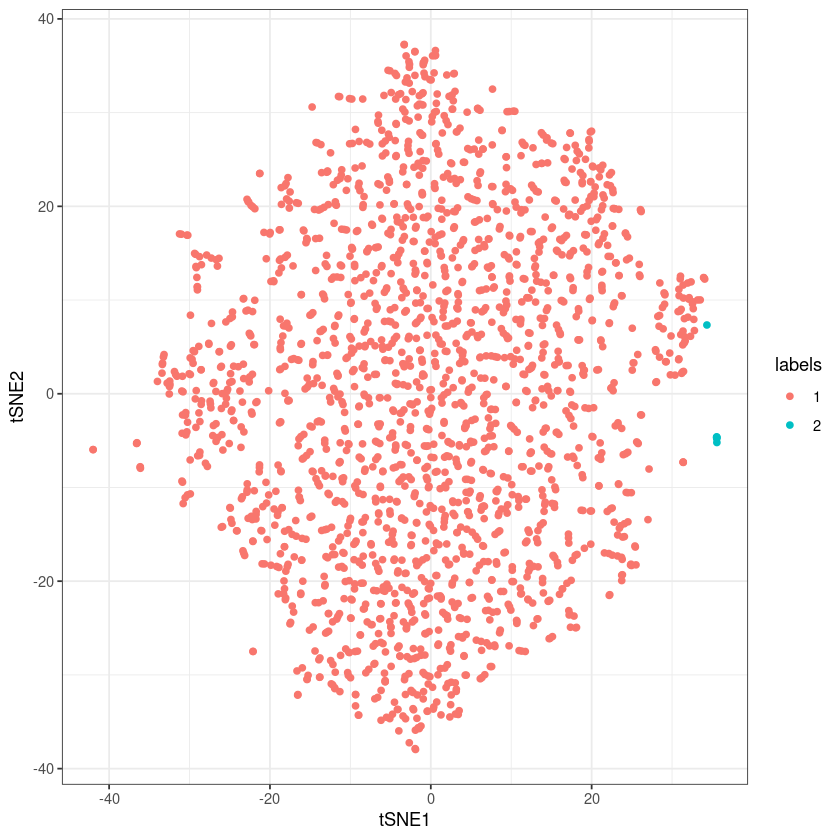

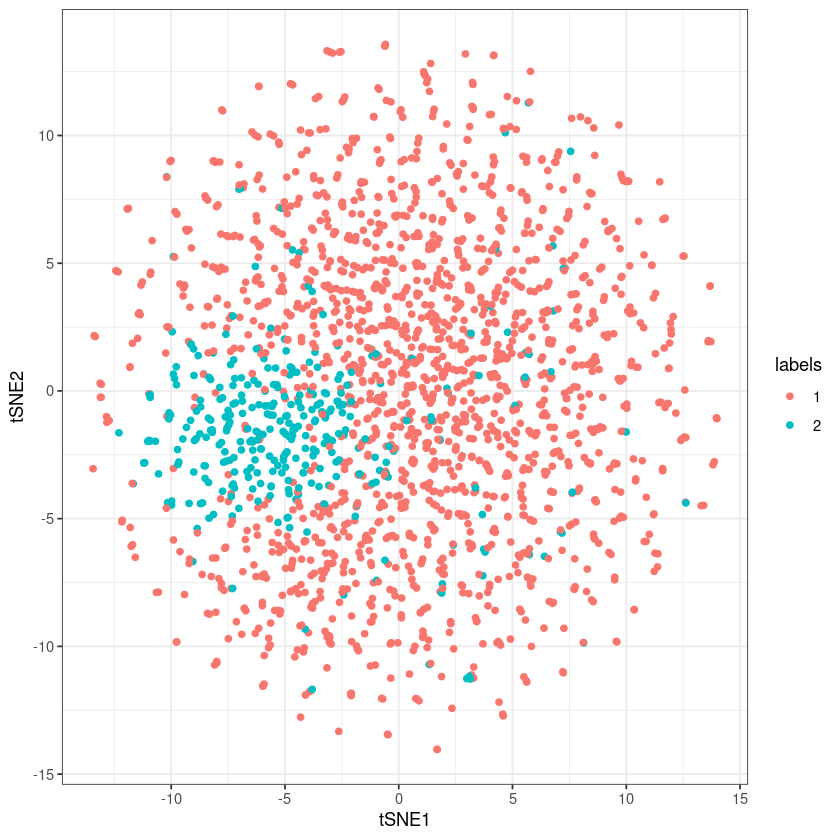

In [12]:
plot_tsne(W,  as.factor(SNF_W_clust$labels))  # Fused network
plot_tsne(W1, as.factor(SNF_W1_clust$labels)) # Metabolites 
plot_tsne(W2, as.factor(SNF_W2_clust$labels)) # SNPs

# Removing potential outliers

From the spectral clustering of $K=2$ only a few samples are clustered together while most samples belong to a single cluster. Those few may be outliers

In [13]:
SNF_W_clust  <- spectralClust(W,  K = 2)
summary(as.factor(SNF_W_clust$labels))

1    2 
2038    6

In [14]:
retain_samples <- SNF_W_clust$labels == 1
snp_dist <- snp_dist[retain_samples, retain_samples]
met_dist <- met_dist[retain_samples, retain_samples]

# Re-running SNF

In [15]:
#### ESTIMATE SIMILARITY GRAPHS
W1 <- affinityMatrix(met_dist, K, alpha)
W2 <- affinityMatrix(snp_dist, K, alpha)
#### RUN SNF
W <- SNF(list(W1,W2), K, T)

[1] 2

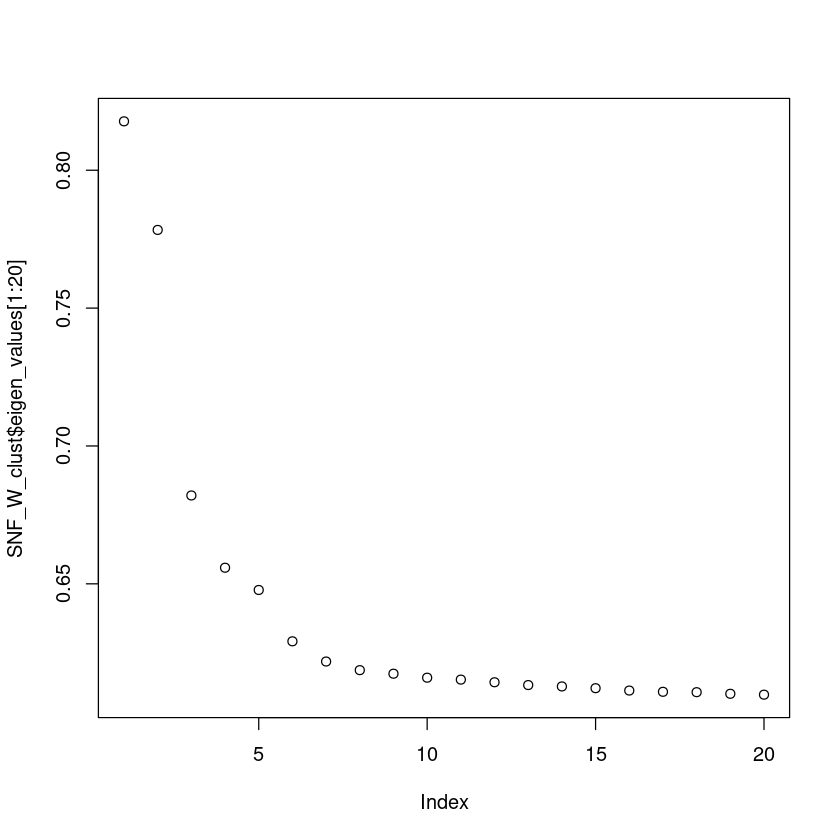

In [16]:
#### HOW MANY CLUSTERS?
SNF_W_clust <- spectralClust(W, 20)
plot(SNF_W_clust$eigen_values[1:20])
which.max(abs(diff(SNF_W_clust$eigen_values[1:20])))

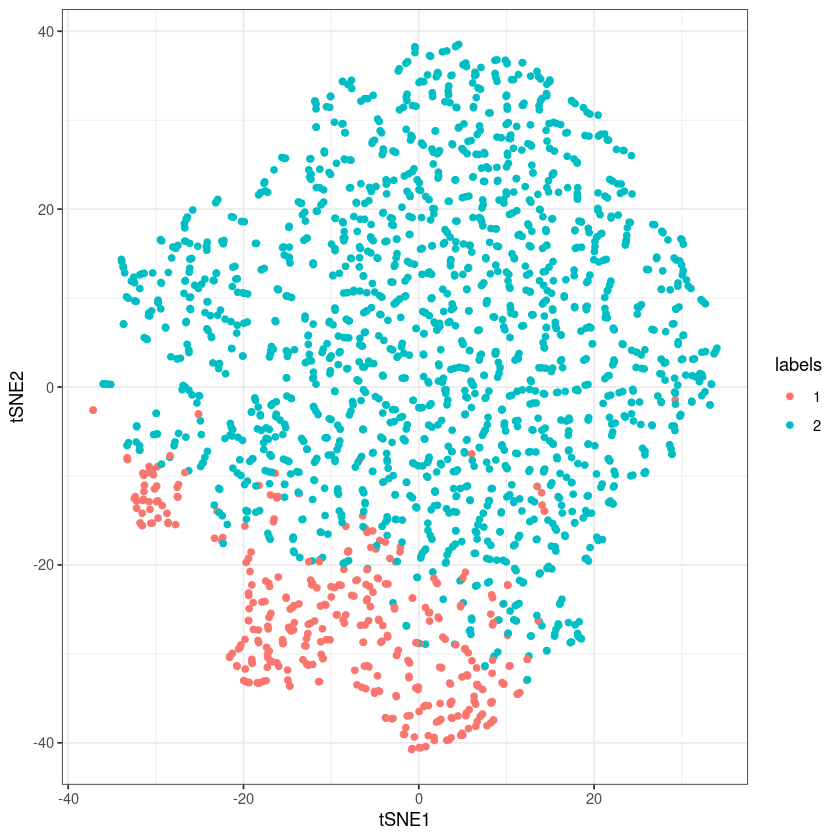

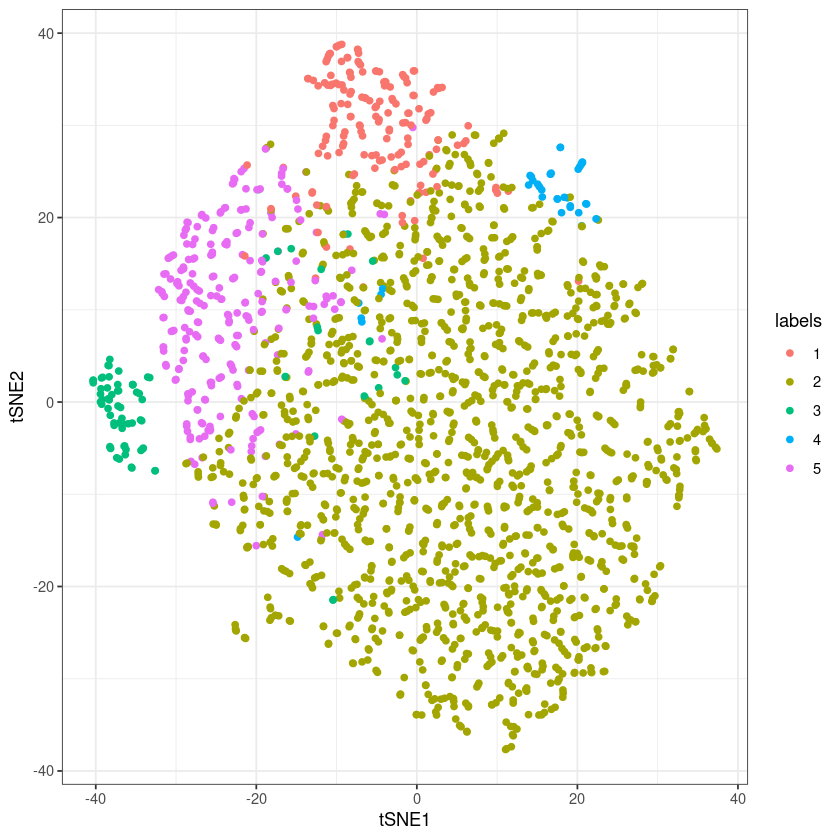

In [18]:
SNF_W_clust  <- spectralClust(W,  K = 2)
plot_tsne(W, as.factor(SNF_W_clust$labels))

SNF_W_clust  <- spectralClust(W,  K = 5)
plot_tsne(W, as.factor(SNF_W_clust$labels))

# Residuals on the metabolites

In [19]:
cov <- cbind(scale(cov[,1:3]), cov[,4:17])

In [20]:
vec <- colnames(cov)
b   <- paste(vec, collapse=' + ')
met_res <- met

for(i in 1:ncol(met)){
    metname <- colnames(met)[i]
    form <- paste(metname, ' ~ ', b ,sep = '')
    fit <- lm(form, data = cbind(met, cov))
    res <- residuals(fit)
    met_res[,i] <- res
}

In [23]:
#### CALCULATE MET_RES DISTANCE
met_res_dist <- dist2(met_res, met_res)
met_res_dist <- met_res_dist[retain_samples, retain_samples] #Remove outliers

In [24]:
#### ESTIMATE SIMILARITY GRAPHS
W1_2 <- affinityMatrix(met_res_dist, K, alpha)
#### RUN SNF
T <- 40
W <- SNF(list(W1_2, W2), K, T)

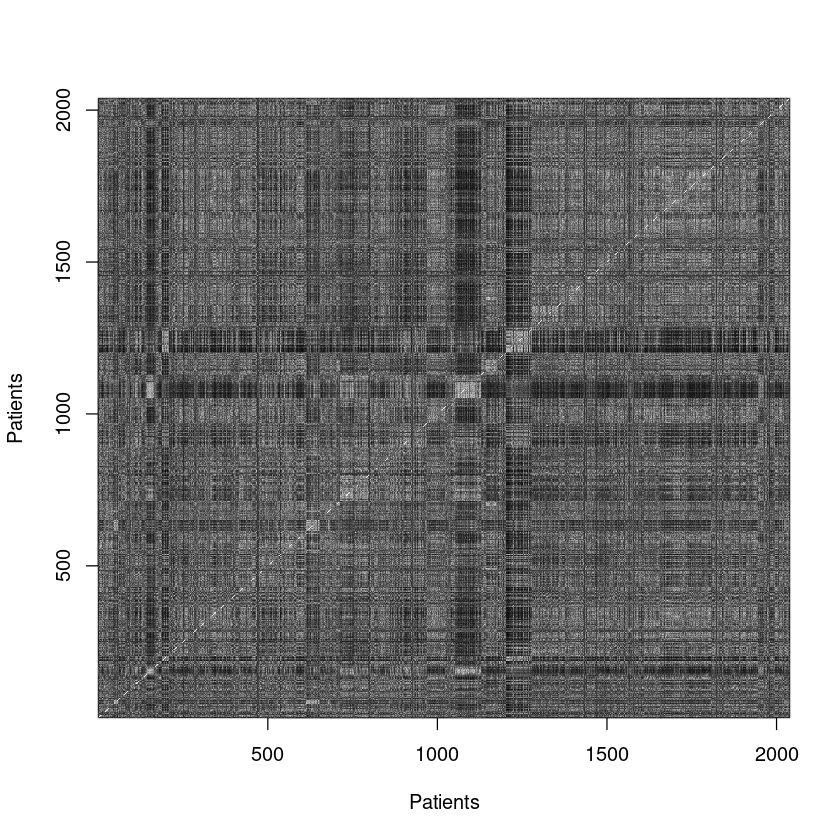

In [26]:
displayClusters(log(W1_2), as.factor(pheno[retain_samples]))

[1] 2

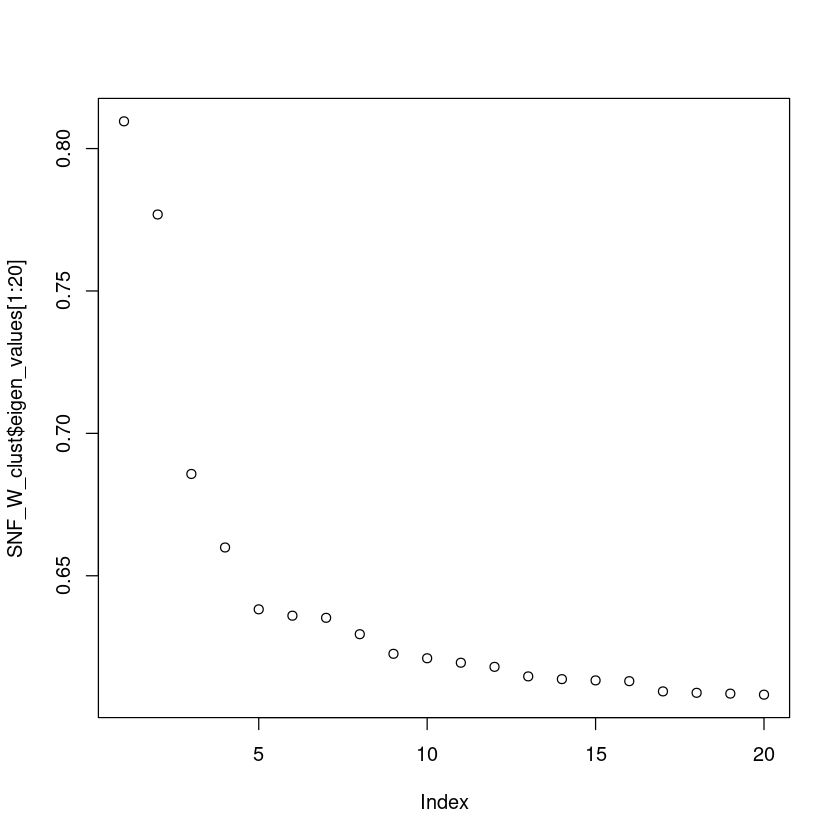

In [27]:
SNF_W_clust <- spectralClust(W, 20)
plot(SNF_W_clust$eigen_values[1:20])
which.max(abs(diff(SNF_W_clust$eigen_values[1:20])))

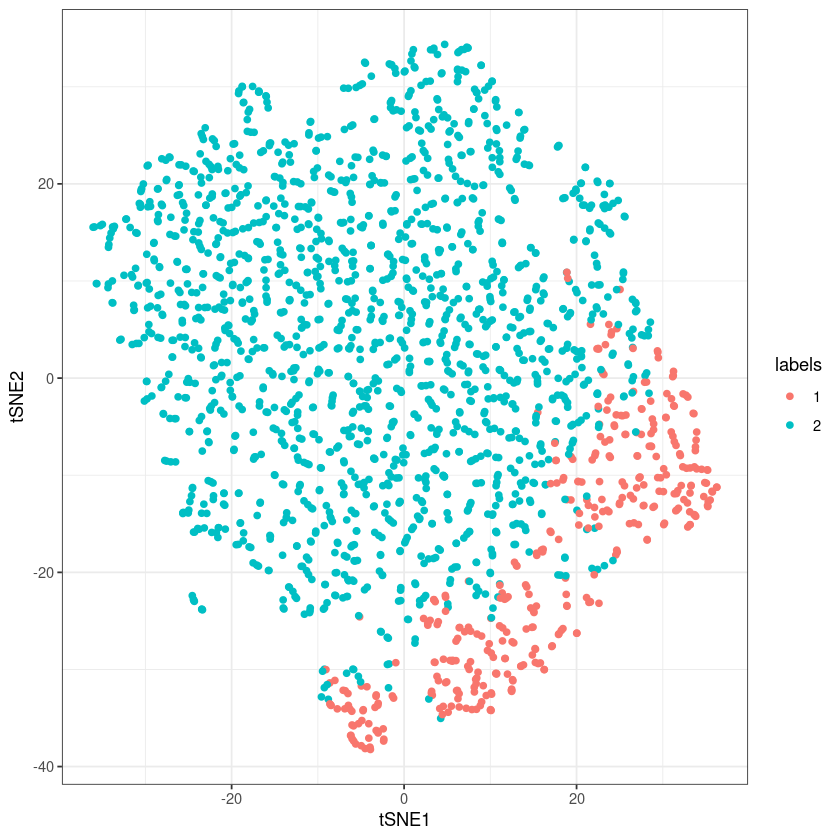

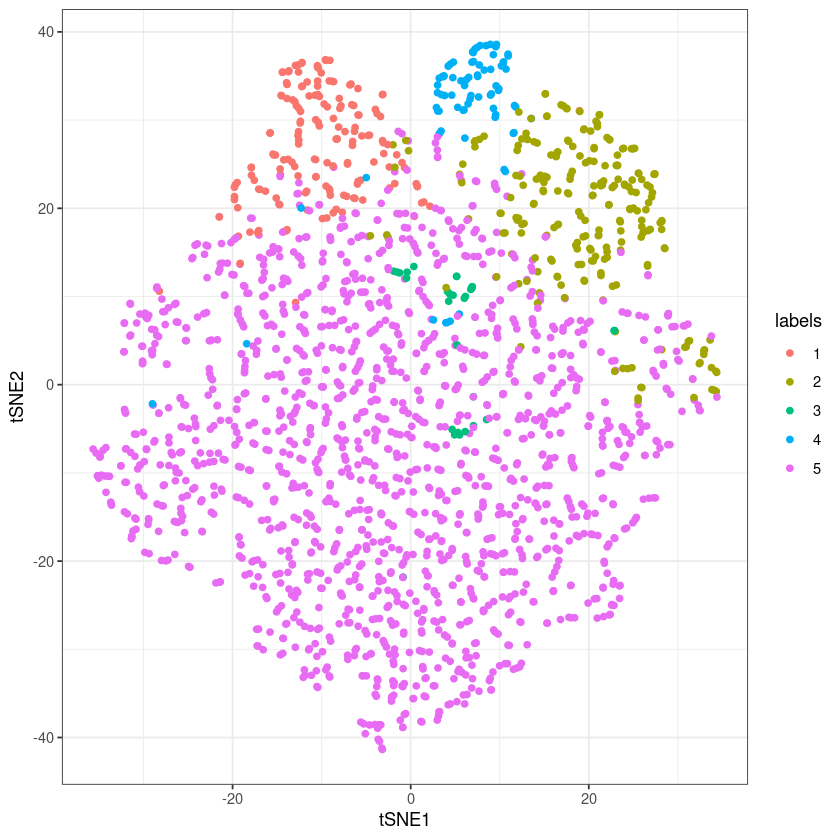

In [28]:
SNF_W_clust  <- spectralClust(W,  K = 2)
plot_tsne(W, as.factor(SNF_W_clust$labels))

SNF_W_clust  <- spectralClust(W,  K = 5)
plot_tsne(W, as.factor(SNF_W_clust$labels))

# Selecting metabolites

In [54]:
met_sig <- c()
for(i in 1:ncol(met_res)){
    model <- glm(pheno ~ met[,i], family=binomial(link='logit'))
    pval  <- coef(summary(model))[,4][2]
    if(pval<0.05){
        met_sig <- append(met_sig, i)
    }
}

In [55]:
#### CALCULATE MET_RES DISTANCE
met_dist <- dist2(met[,met_sig], met[,met_sig])

In [56]:
#### ESTIMATE SIMILARITY GRAPHS
W1 <- affinityMatrix(met_dist, K, alpha)
#### RUN SNF
T <- 40
W <- SNF(list(W1,W2), K, T)

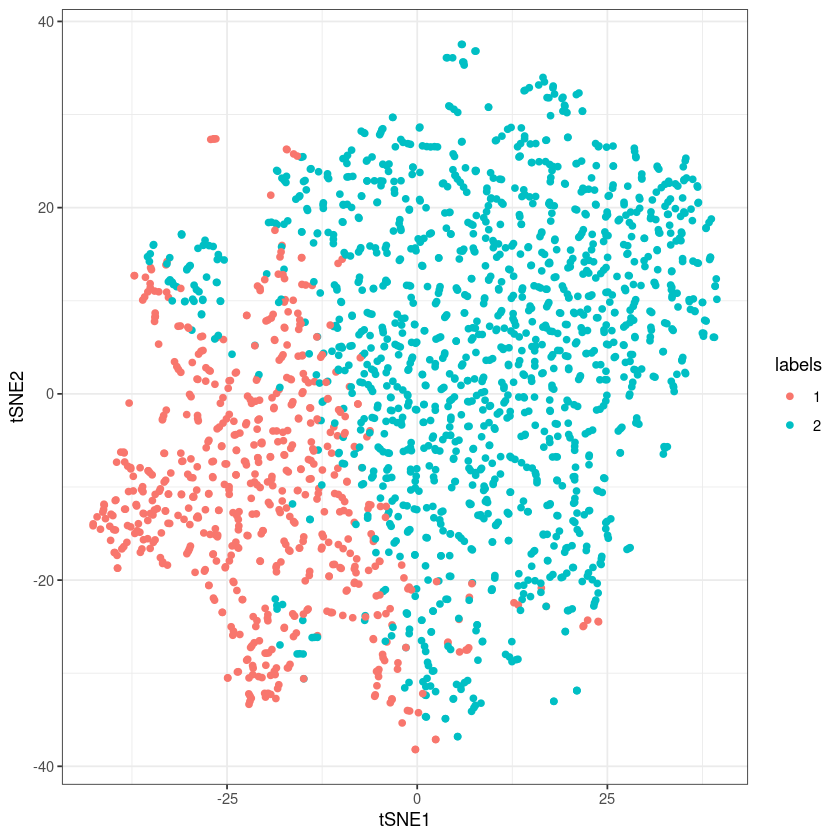

In [60]:
SNF_W1_clust <- spectralClust(W1, K = 2)
plot_tsne(W1, as.factor(SNF_W1_clust$labels))

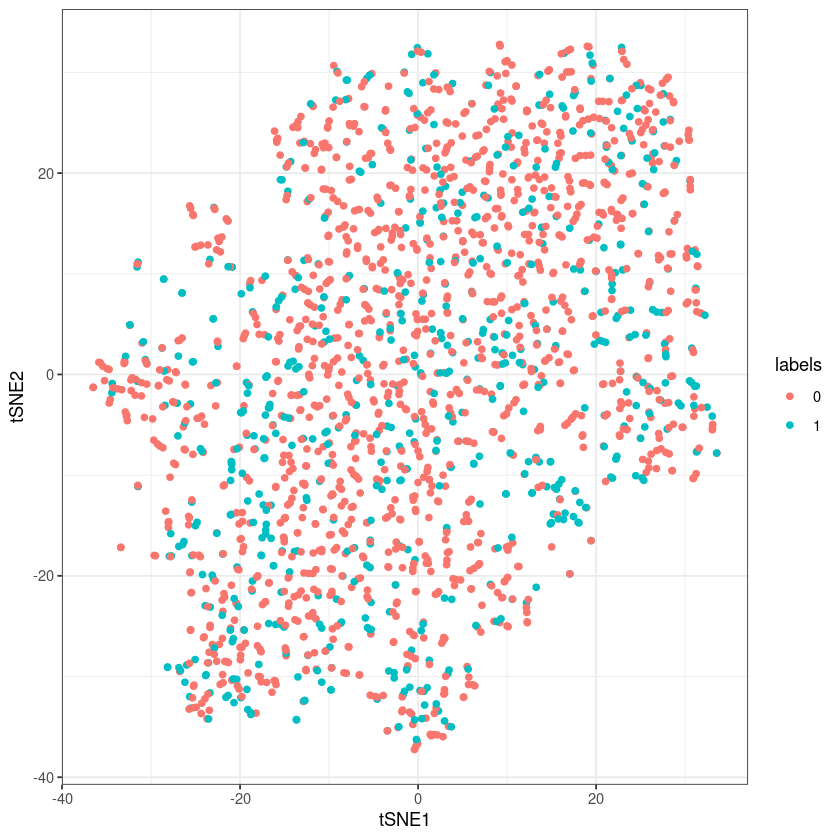

In [90]:
plot_tsne(W1, as.factor(cov$death2010))

In [71]:
cov

age         waihip      bmi         sex cadangio mi012 strokeyn pvdyn
1    -1.82896203 -0.33230582  0.84620801 1   1        0     0        0    
2    -0.45282522  0.91625545 -0.04451795 1   4        2     0        0    
3    -1.08457296 -1.05285939  0.01409534 2   2        0     0        0    
4     1.04392281 -0.06540352  0.07057490 1   4        0     0        0    
5    -0.25623424 -0.54622016 -1.14436316 1   4        0     0        0    
6    -0.20894614  1.22856367 -0.69266279 1   5        1     0        1    
7     0.09975482  0.79937006 -0.13151602 1   5        2     0        0    
8    -1.04445778 -1.69357890 -0.36036313 2   3        0     0        0    
9     0.03360461  0.65845535 -0.53088918 1   3        1     0        0    
10   -1.31570019 -1.48995990 -0.66164224 2   0        0     1        0    
11   -0.57981236  0.66136080 -0.17122821 1   4        0     0        0    
12   -1.88687666 -2.23554370 -0.58834789 2   0        0     0        0    
13   -2.00642523 -0.46394541 -0.23002131 1   3        0     0        0    
14    0.86353731  0.80543640 -0.46385071 1   0        0     0        0    
15   -0.55935627  0.65431952  0.04692774 1   4        0     0        0    
16   -0.08860059  0.38384220 -0.81283461 1   4        1     0        0    
17   -0.46823370  0.39370650  1.18887015 1   2        0     0        0    
18    0.82235947  0.52335155  1.12802342 1   5        0     0        0    
19   -0.67518555 -0.71873173 -0.80662325 1   0        0     0        0    
20   -2.70751114 -0.17419522 -0.75015838 1   3        0     0        0    
21   -0.44512097 -0.18408171  2.10129839 1   3        0     0        0    
22   -0.75515025  0.26141562 -0.63585268 1   0        0     0        0    
23   -0.91959594  0.22486642 -0.87386276 2   0        0     0        0    
24   -1.72004000  0.81840582 -0.85343068 1   5        2     0        0    
25    0.01553949  0.22135483  0.92365640 2   0        0     0        0    
26    0.68846508  0.37582442 -1.18944875 1   4        0     0        1    
27    1.06331625  1.02179274  0.73616596 2   4        2     0        0    
28   -1.78114260 -0.45454258  0.37141842 2   0        0     0        0    
29   -0.46159211  1.45679595  0.97056704 1   5        1     0        0    
30   -0.10188376 -0.83563368 -1.31514814 1   4        0     0        0    
⋮    ⋮           ⋮           ⋮           ⋮   ⋮        ⋮     ⋮        ⋮    
2015  0.42067630  0.15311519 -0.13569390 1   3        1     0        0    
2016 -0.05353301  0.77750721 -0.21383763 1   5        0     0        0    
2017 -0.33221400  0.77750721  0.33065563 1   5        0     0        1    
2018 -0.27642467  0.64676367  0.01287585 1   5        1     0        0    
2019 -1.37281784 -0.71374344 -1.43931785 2   1        0     0        0    
2020 -1.09227720  2.25112124  0.27771663 1   3        1     0        0    
2021  1.59065825 -1.09545969 -0.06731590 1   2        0     0        0    
2022 -0.12845011  0.41174407  0.80738321 1   4        0     0        1    
2023 -1.51175983  0.27413096  0.37123956 1   3        0     0        0    
2024 -0.32371277  0.06496368  1.00406582 2   2        0     0        0    
2025 -0.11702658 -0.73496811  0.02518527 1   4        1     0        0    
2026 -0.95652317  0.10253645  2.14354091 1   3        1     0        0    
2027 -0.34257487 -0.92754573  0.45411720 2   2        0     0        0    
2028 -0.24853000 -0.11203758 -0.80436968 1   2        0     0        0    
2029 -0.53332125 -0.58735753  0.22721492 1   3        1     0        0    
2030  0.43130283  1.22089832 -0.80111217 1   5        1     0        0    
2031 -1.70197488 -1.56928875 -0.90571461 1   3        0     0        0    
2032 -1.60102276  0.39500295  0.51858330 1   3        0     0        0    
2033 -0.28359758  1.07184986  1.89424316 1   5        0     0        0    
2034  0.15634114 -1.81025945 -1.09381081 2   2        0     0        0    
2035  0.53198929 -0.87450455  0.03307681 2   2        0     1        0    
2036  0.82421912 -0.04081814 -

# Network Plot

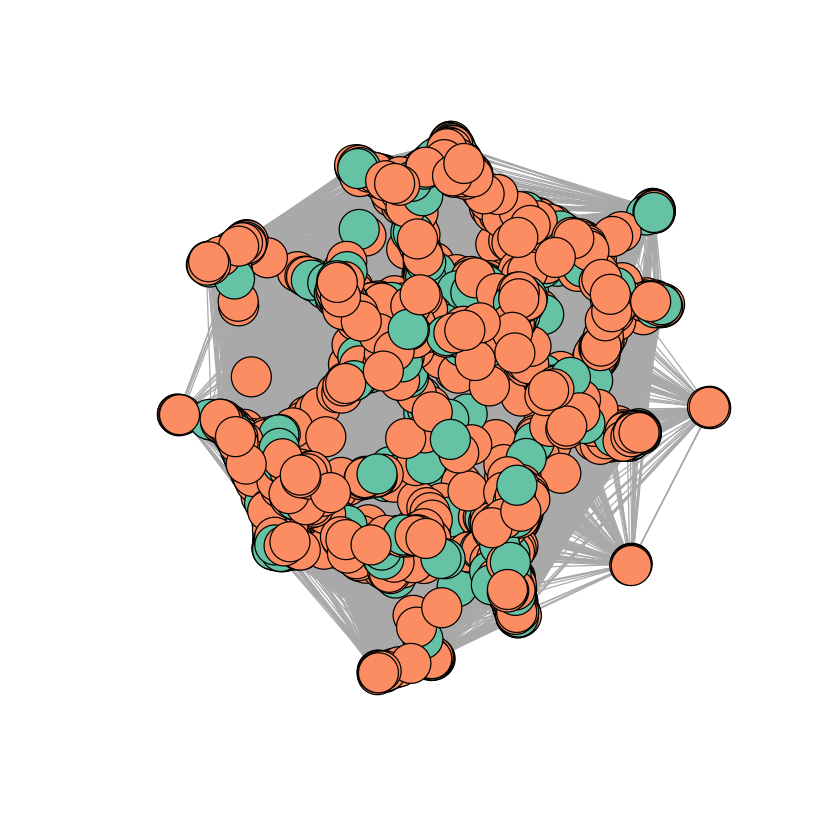

In [106]:
# Plot networks
coul     <- brewer.pal(nlevels(as.factor(mtcars$cyl)), "Set2")
my_color <- coul[as.numeric(as.factor(pheno))]
network  <- graph_from_adjacency_matrix(w, weighted = TRUE, mode = "undirected", diag = FALSE)

plot(network,
     ## VERTEX
     vertex.label=NA,
     vertex.color=my_color)

# SNP modules

The code below was used to generate cluster of related SNPs. However, the correlations among them were too low to create meaningful clusters

In [5]:
#### GENERATE R2 MATRIX
snpnames  <- unlist(strsplit(colnames(snp), '_[A-Z]'))
nsnps     <- length(colnames(snp))
r_matrix <- matrix(0, nsnps, nsnps)
rownames(r_matrix) <- colnames(snp)
colnames(r_matrix) <- colnames(snp)

for(i in 1:(nsnps-1) ){
    n <- i + 1
    for(j in n:nsnps){
        bool_place <- r2$SNP_A == snpnames[i] & r2$SNP_B == snpnames[j]
        val        <- abs(r2$R[bool_place])
        r_matrix[i,j] <- val
        r_matrix[j,i] <- val
    }
}

In [24]:
# Choose a set of soft-thresholding powers
powers <- c(c(1:10), seq(from = 12, to=30, by=2))
# Call the network topology analysis function
sft <- pickSoftThreshold(r_matrix, powerVector = powers, verbose = 5)

# We will choose power of 2 (closer to 1)

pickSoftThreshold: will use block size 189.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 189 of 189
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.   max.k.
1      1  0.00359  0.689         0.9630 1.12e+01  1.11e+01 1.34e+01
2      2  0.48400 -3.840         0.5500 1.05e+00  1.04e+00 1.98e+00
3      3  0.29500 -7.020         0.1250 1.32e-01  1.22e-01 5.57e-01
4      4  0.11400 -3.670         0.1210 2.21e-02  1.64e-02 2.32e-01
5      5  0.19400 -3.110         0.0581 5.34e-03  2.50e-03 1.18e-01
6      6  0.13800 -2.290         0.0822 1.90e-03  4.29e-04 6.55e-02
7      7  0.15800 -2.000         0.0932 8.85e-04  7.33e-05 3.70e-02
8      8  0.19700 -2.110         0.1730 4.70e-04  1.29e-05 2.10e-02
9      9  0.22600 -2.040         0.1650 2.64e-04  2.39e-06 1.24e-02
10    10  0.23900 -1.930         0.1560 1.52e-04  4.57e-07 7.39e-03
11    12  0.16600 -1.430         0.2250 5.23e-05  1.75e-08 2.67e-03
12    14  0.20900 -1.460        

In [21]:
#### STEP-BY-STEP NETWORK CONSTRUCTION
softPower <- 1;
adjacency <- adjacency(r_matrix, power = softPower);

# Turn adjacency into topological overlap
TOM     <- TOMsimilarity(adjacency);
dissTOM <- 1-TOM

#net <- blockwiseModules(r_matrix, power = 2, TOMType = "unsigned", reassignThreshold = 0, mergeCutHeight = 0.25, numericLabels = TRUE, pamRespectsDendro = FALSE, 
#                        saveTOMs = TRUE, saveTOMFileBase = "r_SNP_TOM", verbose = 3)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
